# Latar Belakang

Tidak semua orang mampu membeli mobil baru dari pabrikan. Arab Budget Car (ABC) hadir sebagai solusi bagi orang-orang yang ingin mempunyai mobil namun punya budget terbatas. Arab Budget Car (ABC) adalah sebuah perusahaan jual beli mobil bekas berdomisili di Arab Saudi. Produk yang ditawarkan adalah mobil bekas dari berbagai brand dan tipe. 

Sumber pendapatan utama perusahaan jual beli mobil bekas adalah selisih harga beli mobil dan harga jualnya. Oleh karena itu penting bagi perusahaan untuk dapat membeli dan mejual bekas pada harga yang tepat. Harga yang tepat artinya perusahaan membeli mobil pada harga yang tidak overprice dan menjual mobil pada harga yang tidak underprice.

# Problem Statement

Kondisi di lapangan harga mobil bekas dipengaruhi oleh banyak faktor seperti, jarak tempuh mobil, umur mobil dan brand mobil. Memprediksi harga mobil secara manual butuh effor yang besar. Departemen procurement adalah bagian yang bertanggungjawab untuk sourcing mobil bekas dari perorangan, perusahaan, tempat lelang, dan berbagai sumber lain. Bagian tersebut memerlukan sebuah prediktor yang dapat memprediksi harga mobil bekas di pasar dengan tepat sehingga profit dalam setiap transaksi penjualan mobil dapat maksimal.

# Tujuan

Membangun model machine learning yang dapat membantu memprediksi harga mobil bekas untuk menghindari fenomena overprice dan underprice sehingga memaksimalkan profit transaksi jual/beli mobil bekas dengan cara 

# Rumusan Masalah

1. Apa model machine learning terbaik untuk memprediksi harga mobil bekas?
2. Parameter apa saja yang paling mempengaruhi harga mobil bekas?
3. Seberapa baik akurasi model machine learning dalam memprediksi harga mobil bekas?


# Analytic Approach

Harga mobil bekas merupakan bilangan kontinu. Sehingga pendekatan analisis yang digunakan adalah regresi.

# Metrik Evaluasi

Metrik evaluasi yang digunakan untuk menenilai performa model machine learning adalah R^2 (disingkat R2) dan mean absolut error (MAE).
 
 Sumber: Singh Saini, Prabaljeet, and Lekha Rani. "Performance Evaluation of Popular Machine Learning Models for Used Car Price Prediction." International Conference on Data Analytics and Insights. Singapore: Springer Nature Singapore, 2023.

# Import Library

In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

#Import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders import BinaryEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
#Import scoring metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

#Import model
from xgboost import XGBRegressor, plot_importance
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor

#Import model interpretation
import shap


# Data

In [219]:
data = pd.read_csv("data_saudi_used_cars.csv")

In [220]:
data.head()

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
4,FJ,Riyadh,Toyota,Automatic,Saudi,Full,2020,4.0,49000,True,0


| Kolom | Deskripsi |
| --- | --- |
| **Type** | Tipe/Jenis mobil |
| **Region** | Region di mana mobil dijual |
| **Make** | Brand perusahaan pembuat mobil |
| **Gear_Type** | Tipe transmisi mobil |
| **Options** | Fitur yang ditambahan pada mobil bekas. Full berarti banyak fitur yang ditambahkan pada mobil bekas seperti sunroof, cat mewah, dan velg non standard dll |
| **Year** | Tahun mobil diproduksi |
| **Mileage** | Jarak tempuh mobil |
| **Negotiable** | Apakah harga mobil dapat dinego. Jika true atau price = 0 maka harga mobil dapat dinego|
| **Price** | Harga mobil bekas|


In [221]:
data.shape

(5624, 11)

Dataset mempunyai **5624** baris dan **11** kolom.

# EDA

In [222]:
data_eda = data.copy()

## Price

Text(0.5, 1.0, 'Distribusi harga mobil bekas')

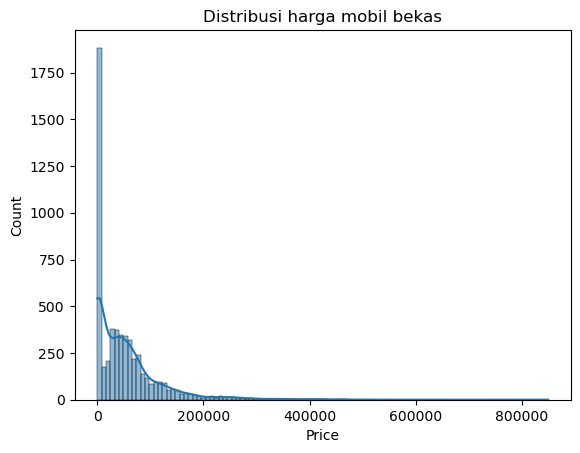

In [223]:
sn.histplot(data=data_eda["Price"], kde=True)
plt.title('Distribusi harga mobil bekas', size=12)

Berdasarkan plot histogram harga mobil bekas di atas. Dapat diketahui bahwa distribusi harga mobil bekas berjenis 'right-skewed'. Jumlah harga mobil yang sama dengan 0 lebih dari 1750. Artinya jumlah harga mobil yang dapat dinego lebih dari 1750 mobil. Pada proses data preprocessing mobil yang harganya sama dengan nol akan didrop karena tidak relevan dengan model yang akan dibuat.

## Region

Text(0.5, 1.0, 'Region mobil asal bekas')

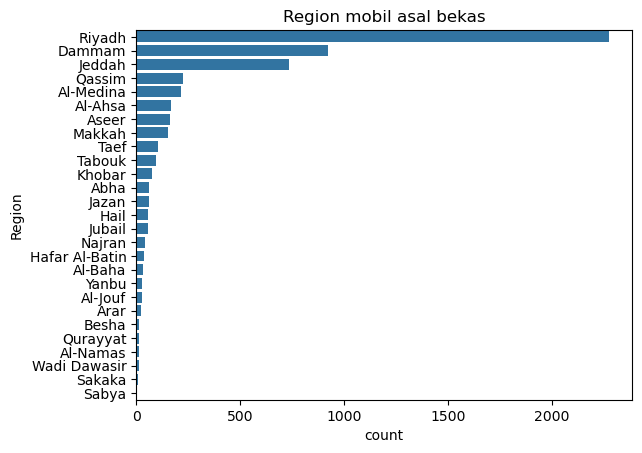

In [224]:
sn.countplot(data=data_eda["Region"], order=data_eda["Region"].value_counts().index)
plt.title('Region mobil asal bekas', size=12)

In [225]:
data_eda["Region"].value_counts()

Region
Riyadh            2272
Dammam             925
Jeddah             733
Qassim             225
Al-Medina          214
Al-Ahsa            166
Aseer              163
Makkah             153
Taef               103
Tabouk              97
Khobar              76
Abha                64
Jazan               60
Hail                58
Jubail              56
Najran              42
Hafar Al-Batin      39
Al-Baha             35
Yanbu               27
Al-Jouf             27
Arar                22
Besha               16
Qurayyat            13
Al-Namas            12
Wadi Dawasir        12
Sakaka              10
Sabya                4
Name: count, dtype: int64

Kebanyakan mobil yang dijual berasal dari daerah Riyadh dengan jumlah 2272 mobil. Sedangan mobil yang dijual dari daerah sabya hanya sebanyak 4 mobil.

In [226]:
data_eda[data_eda["Region"] == "Riyadh"].groupby(['Region','Make'])["Make"].count().sort_values(ascending=False)

Region  Make      
Riyadh  Toyota        491
        Hyundai       327
        Ford          211
        Chevrolet     197
        Nissan        181
        GMC           112
        Kia           103
        Mercedes       92
        Lexus          87
        Honda          45
        Mazda          43
        BMW            40
        Land Rover     38
        Mitsubishi     35
        Dodge          34
        Genesis        26
        Chrysler       26
        Renault        24
        Jeep           19
        Changan        19
        Audi           15
        Cadillac       14
        Geely          11
        MG              9
        Isuzu           9
        INFINITI        8
        Volkswagen      7
        Porsche         6
        HAVAL           5
        Fiat            5
        Suzuki          4
        Peugeot         4
        Hummer          3
        Lincoln         3
        MINI            3
        Jaguar          2
        GAC             2
        Foton      

Kebanyakan mobil yang dijula dari daerah Riyadh adalah brand Toyaota, Hyundai, dan Ford

## Brand mobil bekas

Text(0.5, 0, 'Jumlah mobil')

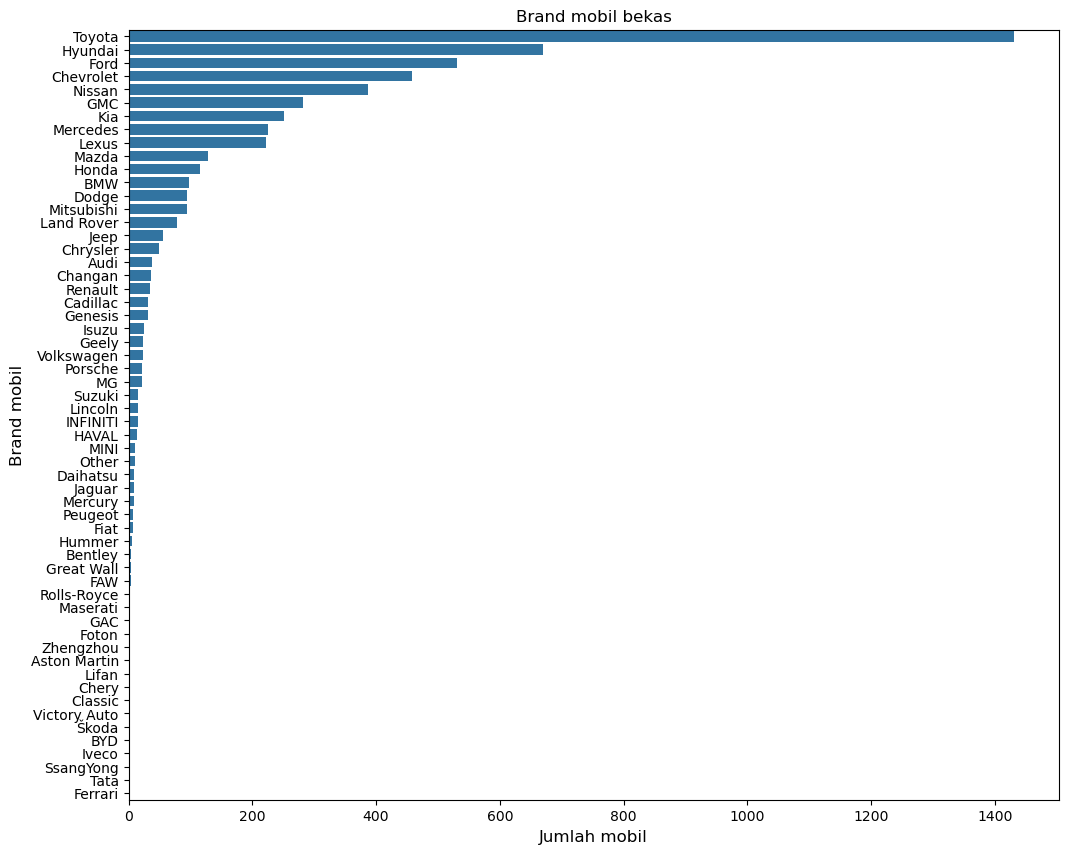

In [227]:
plt.figure(figsize=(12,10))
sn.countplot(data=data_eda["Make"], order=data_eda["Make"].value_counts().index)
plt.title('Brand mobil bekas', size=12)
plt.ylabel('Brand mobil', size=12)
plt.xlabel('Jumlah mobil', size=12)

In [228]:
data_eda["Make"].value_counts().reset_index().head()

,Make,count
0,Toyota,1431
1,Hyundai,670
2,Ford,530
3,Chevrolet,458
4,Nissan,387


Toyota, Hyundai, dan Ford, Chevrolet, dan Nissan adalah 3 brand yang mendominasi pasar mobil bekas di arab asudi.

## Transmission

Text(0.5, 0, 'Tipe Transmisi')

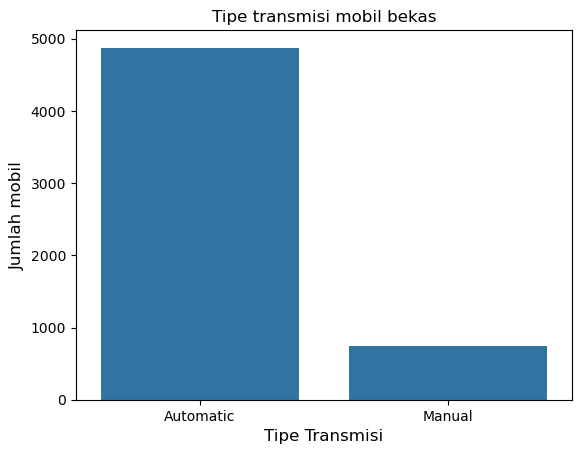

In [229]:
sn.countplot(data=data_eda, x=data_eda["Gear_Type"], order=data_eda["Gear_Type"].value_counts().index)
plt.title('Tipe transmisi mobil bekas', size=12)
plt.ylabel('Jumlah mobil', size=12)
plt.xlabel('Tipe Transmisi', size=12)

In [230]:
data_eda["Gear_Type"].value_counts().reset_index().head()

,Gear_Type,count
0,Automatic,4875
1,Manual,749


Pasar mobil bekas di arab saudi lebih menyukai tipe transmisi otomatis dibanding dengan tipe transmisi manual

## Origin

Text(0.5, 0, 'Asal mobil')

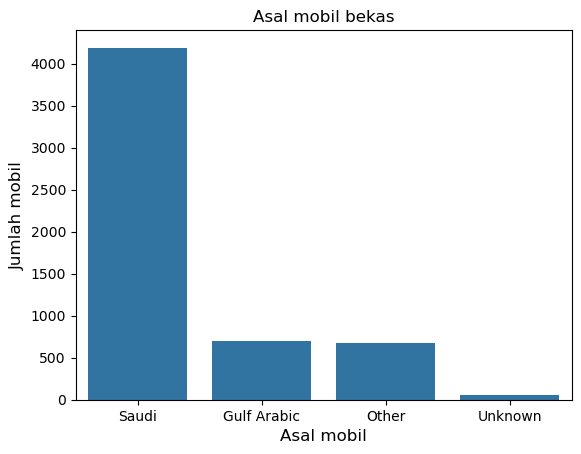

In [231]:
sn.countplot(data=data_eda, x=data_eda["Origin"],order=data_eda["Origin"].value_counts().index)
plt.title('Asal mobil bekas', size=12)
plt.ylabel('Jumlah mobil', size=12)
plt.xlabel('Asal mobil', size=12)

In [232]:
origin_eda = data_eda["Origin"].value_counts().reset_index().head()
origin_eda['Percentage'] = origin_eda["count"]/sum(origin_eda["count"]) * 100
origin_eda

,Origin,count,Percentage
0,Saudi,4188,74.466572
1,Gulf Arabic,697,12.393314
2,Other,678,12.055477
3,Unknown,61,1.084637


Sebanyak 74% mobil bekas berasal dari dalam negeri arab saudi, sisanya sebanyak 26% berasal dari luar arab saudi.

## Options

Text(0.5, 0, 'Tipe Options')

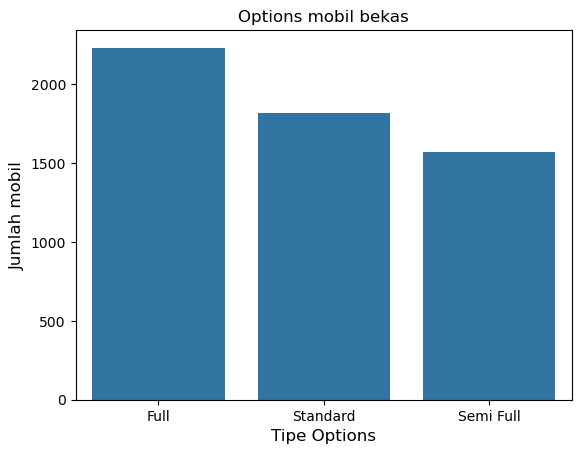

In [233]:
sn.countplot(data=data_eda, x=data_eda["Options"],order=data_eda["Options"].value_counts().index)
plt.title('Options mobil bekas', size=12)
plt.ylabel('Jumlah mobil', size=12)
plt.xlabel('Tipe Options', size=12)

In [234]:
origin_eda = data_eda["Options"].value_counts().reset_index().head()
origin_eda['Percentage'] = origin_eda["count"]/sum(origin_eda["count"]) * 100
origin_eda

,Options,count,Percentage
0,Full,2233,39.704836
1,Standard,1822,32.396871
2,Semi Full,1569,27.898293


Sebanyak 39% mobil yang beredar di pasar mobil bekas telah mengalami full upgrade, 32% masih dalam kondisi standard, dan 28% persen semi full upgrade

## Ukuran Mesin

Text(0.5, 0, 'Ukuran Mesin')

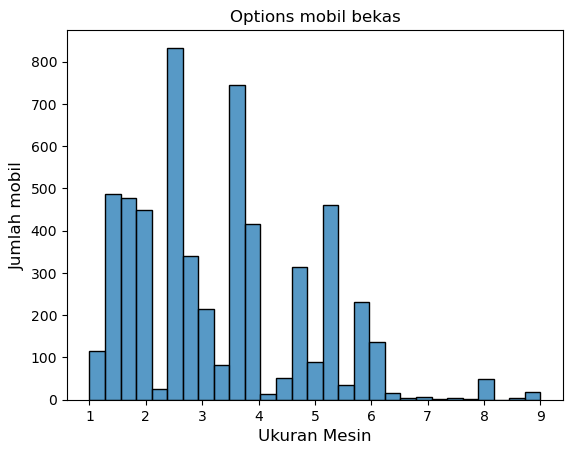

In [235]:
sn.histplot(data=data_eda["Engine_Size"])
plt.title('Options mobil bekas', size=12)
plt.ylabel('Jumlah mobil', size=12)
plt.xlabel('Ukuran Mesin', size=12)

Satuan yang digunakan untuk mengukur ukuran mesin tidak dijelaskan pada data dictionary. Berdasarkan data yang di atas jumlah mobil dengan ukuran mesin sekitar 2,5 punya jumlah terbanyak yaitu mencapai lebih dari 800 mobil.

## Jarak Tempuh

<Axes: xlabel='Mileage', ylabel='Count'>

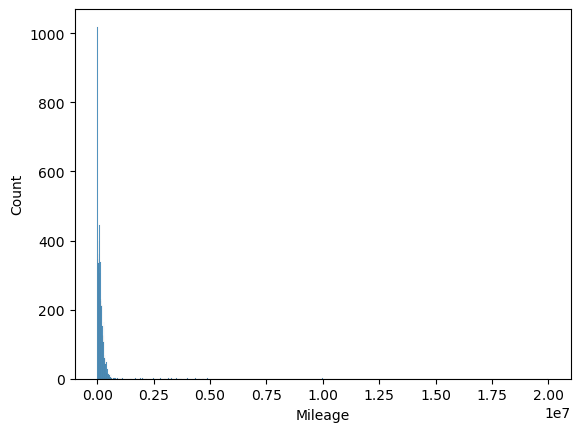

In [236]:
sn.histplot(data=data_eda["Mileage"])

In [237]:
max_mileage = data_eda["Mileage"].max()
min_mileage = data_eda["Mileage"].min()
range_mileage = max_mileage-min_mileage
print(f"Max mileage: {max_mileage}\nMin mileage: {min_mileage}\nRange: {range_mileage}")


Max mileage: 20000000
Min mileage: 100
Range: 19999900


Pada data dictionary tidak disebutkan satuan pengukuran jarak tempuh yang digunakan. .Kita akan mengasumsikan mil adalah satuan yang digunakan. Berdasarkan plot di atas fitur jarak tempuh bertipe "righ-skewed". Range data mileage sangat besar yaitu sebesar 19999900 mil. Denga nilai mileage terbesar 20.000.000. Bedasarkan riset yang saya lakukan sangat jarang ada mobil yang bisa menempuh jarak 20.000.000. Data mileage ini perlu dibersihkan pada proses data preprocessing.

# Data Preprocessing

Pada tahap data preprocesing akan dilakukan pengecekan missing value, data duplikat, konsistensi data, drop kolom, feature engineering, dan pengecekan outlier sehingga dapat menjadi bersih dan siap untuk dijadikan bahan training model machine learning

In [238]:
data_prep = data_eda.copy() # copy data eda

## Missing Value

In [239]:
data_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5624 entries, 0 to 5623
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Type         5624 non-null   object 
 1   Region       5624 non-null   object 
 2   Make         5624 non-null   object 
 3   Gear_Type    5624 non-null   object 
 4   Origin       5624 non-null   object 
 5   Options      5624 non-null   object 
 6   Year         5624 non-null   int64  
 7   Engine_Size  5624 non-null   float64
 8   Mileage      5624 non-null   int64  
 9   Negotiable   5624 non-null   bool   
 10  Price        5624 non-null   int64  
dtypes: bool(1), float64(1), int64(3), object(6)
memory usage: 445.0+ KB


In [240]:
data_prep.isnull().sum()

Type           0
Region         0
Make           0
Gear_Type      0
Origin         0
Options        0
Year           0
Engine_Size    0
Mileage        0
Negotiable     0
Price          0
dtype: int64

Setelah dilakukan pengecekan. Tidak terdapat null value pada dataset ini. Sehingga perlu ada proses pengisian missing value.

## Duplicate Value

Tidak terdapat kolom unique pada dataset ini sehingga tidak perlu dilakukan pengecekan duplicate value.

## Data Konsistensi

In [241]:
data_prep.head()

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
4,FJ,Riyadh,Toyota,Automatic,Saudi,Full,2020,4.0,49000,True,0


In [242]:
data_prep.Type.unique()

array(['Corolla', 'Yukon', 'Range Rover', 'Optima', 'FJ', 'CX3',
       'Cayenne S', 'Sonata', 'Avalon', 'LS', 'C300', 'Land Cruiser',
       'Hilux', 'Tucson', 'Caprice', 'Sunny', 'Pajero', 'Azera', 'Focus',
       '5', 'Spark', 'Camry', 'Pathfinder', 'Accent', 'ML', 'Tahoe',
       'Yaris', 'Suburban', 'A', 'Altima', 'Traverse', 'Expedition',
       'Senta fe', 'Liberty', '3', 'X', 'Elantra', 'Land Cruiser Pickup',
       'VTC', 'Malibu', 'The 5', 'A8', 'Patrol', 'Grand Cherokee', 'SL',
       'Previa', 'SEL', 'Aveo', 'MKZ', 'Victoria', 'Datsun', 'Flex',
       'GLC', 'ES', 'Edge', '6', 'Escalade', 'Innova', 'Navara', 'H1',
       'G80', 'Carnival', 'Symbol', 'Camaro', 'Accord', 'Avanza',
       'Land Cruiser 70', 'Taurus', 'C5700', 'Impala', 'Optra', 'S',
       'Other', 'Cerato', 'Furniture', 'Murano', 'Explorer', 'LX',
       'Pick up', 'Charger', 'H6', 'BT-50', 'Hiace', 'Ranger', 'Fusion',
       'Rav4', 'Ciocca', 'CX9', 'Kona', 'Sentra', 'Sierra', 'Durango',
       'CT-S', 'Sylv

In [243]:
#Mengambil nama kolom pada dataset
column_name = data_prep.columns
column_name

Index(['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options', 'Year',
       'Engine_Size', 'Mileage', 'Negotiable', 'Price'],
      dtype='object')

In [244]:
#Mengambil nilai unique dari setipa kolom dan menghitung jumlah data uniqe pada setiap kolom
list_unique = []
unique_count = []
for coulumn in column_name:
    unique = data_prep[f"{coulumn}"].unique()
    nunique = data_prep[f"{coulumn}"].nunique()
    list_unique.append(unique)
    unique_count.append(nunique)

In [245]:
#Summary nilai unique pada setipa kolom
df_unique = pd.DataFrame(
    {"Value":list_unique,
     "Count_Unique":unique_count},
     index=column_name)

In [246]:
df_unique

,Value,Count_Unique
Type,"[Corolla, Yukon, Range Rover, Optima, FJ, CX3,...",347
Region,"[Abha, Riyadh, Hafar Al-Batin, Aseer, Makkah, ...",27
Make,"[Toyota, GMC, Land Rover, Kia, Mazda, Porsche,...",58
Gear_Type,"[Manual, Automatic]",2
Origin,"[Saudi, Gulf Arabic, Other, Unknown]",4
Options,"[Standard, Full, Semi Full]",3
Year,"[2013, 2014, 2015, 2020, 2019, 2012, 2016, 199...",50
Engine_Size,"[1.4, 8.0, 5.0, 2.4, 4.0, 2.0, 4.8, 3.5, 4.6, ...",71
Mileage,"[421000, 80000, 140000, 220000, 49000, 25000, ...",1716
Negotiable,"[True, False]",2


* Terdapat 327 tipe mobil unik pada data set ini. Berhubung banyaknya jumlah unique value dan sifatnya nominal, maka pada saat modeling akan digunakan BinaryEncoder untuk memproses data kategori ini.
* Terdapat 27 region unik pada data set ini. Berhubung banyaknya jumlah unique value dan sifatnya nominal, maka pada saat modeling akan digunakan BinaryEncoder untuk memproses data kategori ini.
* Terdapat 58 brand pabrikan mobil unik pada dataset ini. Berhubung banyaknya jumlah unique value dan sifatnya nominal, maka pada saat modeling akan digunakan BinaryEncoder untuk memproses data kategori ini.
* Gear_Type, Origin, dan Option jumlah unik valuenya sedikit. Oleh karena itu akan digunkan OneHotEncoder untuk memproses data ini. Drop first akan diaktifkan untuk mencegah multicolinearity.
* Negotialbe akan didrop karena tidak relevan model machine learning.

## Drop Kolom


Pada tahap ini kolom yang tidak relevan dengan pembuatan machine learning akan didrop.

Berdasarkan data dictionary terdapat kolom "Negotiable". Kolom ini memberikan informasi apakah harga mobil bisa dinego atau tidak. Jika dapat dinego maka harga mobil akan diset menjadi nol. Aktualnya harga nol berarti mobil gratis. Hal ini akan membuat model menjadi bias. Oleh karena itu kolom `Negotiable` dan `Price` yang nilainya nol akan didrop.

In [247]:
data_prep.drop(data_prep[data_prep['Price'] == 0].index, inplace=True) # Drop baris dengan nilai price = 0
data_prep.drop(columns='Negotiable', inplace=True) # Drop kolom negotiable

In [248]:
row_eda = data_eda.shape[0]
kolom_eda = data_eda.shape[1]
row_prep = data_prep.shape [0]
kolom_prep = data_prep.shape [1]
print(f"Jumlah baris & kolom sebelum didrop:\nBaris: {row_eda}\nKolom: {kolom_eda}\n")
print(f"Jumlah baris & kolom setelah didrop:\nBaris: {row_prep}\nKolom: {kolom_prep}\n")
print(f"Jumlah pengurangan:\nKolom: {kolom_eda-kolom_prep}\nBaris: {row_eda-row_prep}")

Jumlah baris & kolom sebelum didrop:
Baris: 5624
Kolom: 11

Jumlah baris & kolom setelah didrop:
Baris: 3827
Kolom: 10

Jumlah pengurangan:
Kolom: 1
Baris: 1797


## Feature Engineering

Pada tahap ini kolom `Year` akan diubah menjadi `car_age`. Berdasarkan referensi yang saya baca Hal ini dilakukan agar model dapat menginterprestasikan linearitas informasi `year`.

In [249]:
data_prep['car_age'] = 2025-data_prep['Year'] #mengnitung car_age
data_prep.drop(columns="Year", inplace=True) #drop kolom `year`

In [250]:
data_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3827 entries, 1 to 5622
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Type         3827 non-null   object 
 1   Region       3827 non-null   object 
 2   Make         3827 non-null   object 
 3   Gear_Type    3827 non-null   object 
 4   Origin       3827 non-null   object 
 5   Options      3827 non-null   object 
 6   Engine_Size  3827 non-null   float64
 7   Mileage      3827 non-null   int64  
 8   Price        3827 non-null   int64  
 9   car_age      3827 non-null   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 328.9+ KB


Kolom `year` sudah hilang dan digantikan oleh kolom `car_age`.

## Outlier

In [251]:
#Definisi fungsi untuk mendeteksi outlier
def detect_outlier(df, kolom_df):
    q1 = kolom_df.quantile(0.25)
    q3 = kolom_df.quantile(0.75)
    iqr = q3-q1
    limit = iqr*1.5
    lower_limit = q1-limit
    upper_limit = q3+limit
    count_exceed_upper = len(df[kolom_df > upper_limit])
    count_exceed_lower = len(df[kolom_df < lower_limit])
    
    print(f"Upper Limit: {upper_limit}")
    print(f"Lower Limit: {lower_limit}")
    print(f"Interquartile range: {iqr}")
    print(f"Outlier Upper: {count_exceed_upper}")
    print(f"Outlier Lower: {count_exceed_lower}")

Pada tahap ini akan dilakukan pengecekan outliear pada setiap kolom numerical

<Axes: >

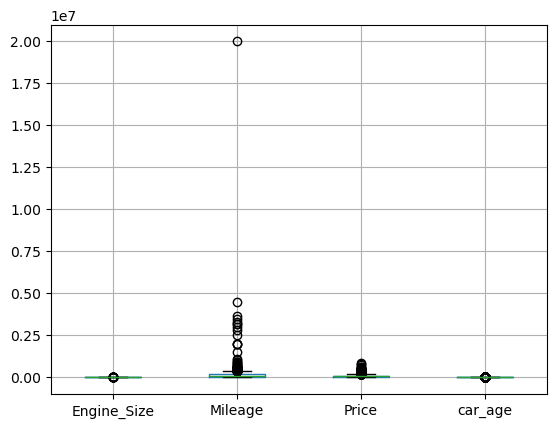

In [252]:
data_prep.boxplot()

Berdasarkan hasil boxploting terlihat setiap kolom mempunyai outlier. Mari telaah lebih lanjut setiap fitur yang mempunyai outlier. Outlier akan dihtung menggunakan metode IQR dan akan diputuskan apakah outlier akan tetap disimpan atau didrop berdasarkan domain knowledge.

### Mileage

<Axes: ylabel='Mileage'>

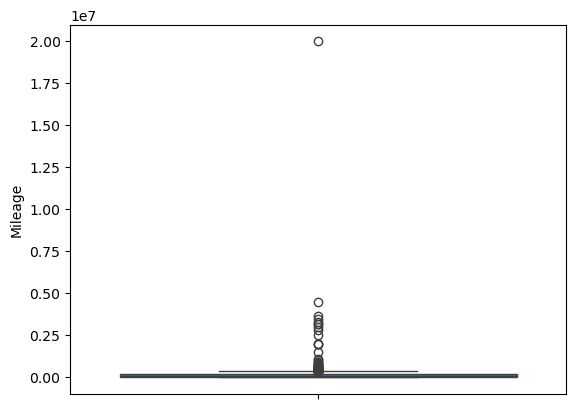

In [253]:
sn.boxplot(data_prep["Mileage"])

In [254]:
detect_outlier(data_prep, data_prep["Mileage"])

Upper Limit: 385500.0
Lower Limit: -154500.0
Interquartile range: 135000.0
Outlier Upper: 131
Outlier Lower: 0


In [255]:
data_prep["Mileage"].describe()

count    3.827000e+03
mean     1.426204e+05
std      3.782584e+05
min      1.000000e+02
25%      4.800000e+04
50%      1.030000e+05
75%      1.830000e+05
max      2.000000e+07
Name: Mileage, dtype: float64

Berdasarkan grafik dan perhitungan IQR terdapat 131 data yang melebihi nilai upper limit iqr 385500 mil. Nilai max mileage sebear 20.000.000 menyebabkan plot distribusi mielage mempunyai tail yang panjang ke arah kanan. Oleh karena itu 131 data yang melebihi upper limit akan didrop. Hal tersebut senada dengan sumber berikut yang menyebutkan kebanyakan jarak tempuh mobil selama hidupnya dapat berkisar antara 200.000 sampai 300.000 mil. https://www.ourcar.co.uk/blog/how-many-miles-can-a-car-last-a-comprehensive-guide

In [256]:
data_prep.drop(data_prep[data_prep['Mileage'] > 385500.0].index, inplace=True) # Drop baris dengan nilai mileage > 385500.0

Text(0, 0.5, 'Jumlah Mobil')

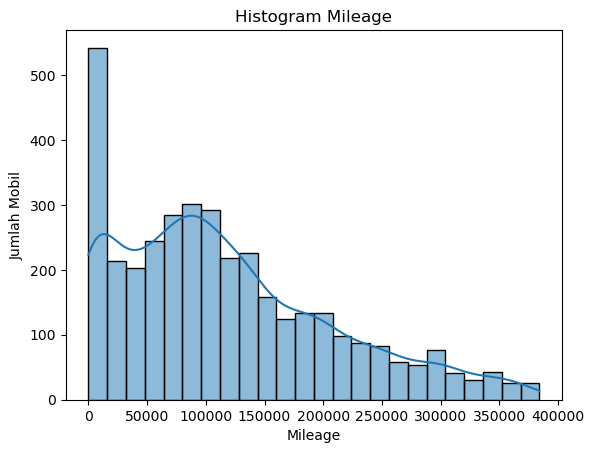

In [257]:
sn.histplot(data_prep["Mileage"], kde=True)
plt.title("Histogram Mileage")
plt.ylabel("Jumlah Mobil")

In [258]:
data_prep["Mileage"].describe()

count      3696.000000
mean     116843.168019
std       91799.238574
min         100.000000
25%       45277.500000
50%       99000.000000
75%      173000.000000
max      384000.000000
Name: Mileage, dtype: float64

Setelah dilakukan filtering outlier maka nilai max mileage menjadi 384000 dan nilai min mileage menjadi 100.

### Engine Size

<Axes: ylabel='Engine_Size'>

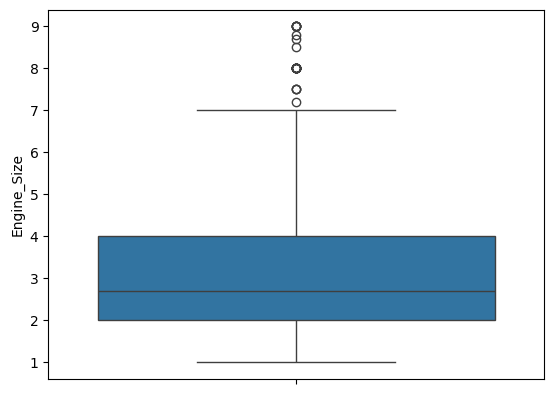

In [259]:
sn.boxplot(data_prep["Engine_Size"])

In [260]:
detect_outlier(data_prep,data_prep["Engine_Size"])

Upper Limit: 7.0
Lower Limit: -1.0
Interquartile range: 2.0
Outlier Upper: 30
Outlier Lower: 0


In [261]:
data_prep["Engine_Size"].describe()

count    3696.000000
mean        3.169237
std         1.459200
min         1.000000
25%         2.000000
50%         2.700000
75%         4.000000
max         9.000000
Name: Engine_Size, dtype: float64

50% mobil punya ukuran mesin kurang dari 2.7 dan 75% mobil punya ukurang mesin kurang dari 75%. Ukuran mesin paling besar adalah 9. Terdapat 30 mobil yang ukuran mesinnya di atas nilai upper limit yaitu 7.0. Kita akan random cek nilai engine size dan menyamakan nya denga data engine size mobil tipe yang sama. Jika berbeda kita akan drop data engine size yang melebihi 7.0

In [262]:
data_prep[data_prep["Engine_Size"] > 7]

,Type,Region,Make,Gear_Type,Origin,Options,Engine_Size,Mileage,Price,car_age
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,8.0,80000,120000,11
59,Camry,Taef,Toyota,Automatic,Saudi,Semi Full,9.0,150000,15000,24
600,G,Riyadh,Mercedes,Automatic,Saudi,Full,8.8,213000,240000,10
650,E,Jeddah,Mercedes,Manual,Other,Semi Full,9.0,134000,155000,8
750,LX,Taef,Lexus,Automatic,Gulf Arabic,Full,7.5,122000,340000,7
883,Cadillac,Riyadh,Classic,Automatic,Saudi,Full,8.0,119,25000,30
963,D-MAX,Abha,Isuzu,Manual,Saudi,Full,7.5,40000,125000,6
1057,F150,Riyadh,Ford,Automatic,Saudi,Standard,8.0,147000,80000,11
1166,Land Cruiser,Hail,Toyota,Automatic,Saudi,Full,8.0,295000,65000,17
1199,Other,Qassim,Other,Manual,Other,Full,8.0,24643,330000,6


In [263]:
data_prep[data_prep["Type"] == "D-MAX"]

,Type,Region,Make,Gear_Type,Origin,Options,Engine_Size,Mileage,Price,car_age
963,D-MAX,Abha,Isuzu,Manual,Saudi,Full,7.5,40000,125000,6
1143,D-MAX,Riyadh,Isuzu,Manual,Saudi,Standard,2.5,275000,55500,9
2238,D-MAX,Dammam,Isuzu,Manual,Saudi,Standard,2.5,288000,42000,11
3400,D-MAX,Riyadh,Isuzu,Manual,Saudi,Standard,2.5,39000,72000,7
3682,D-MAX,Riyadh,Isuzu,Manual,Saudi,Standard,2.5,203957,68500,7
5388,D-MAX,Riyadh,Isuzu,Manual,Saudi,Standard,2.5,52849,69500,7


In [264]:
data_prep[data_prep["Type"] == "Grand Cherokee"]

,Type,Region,Make,Gear_Type,Origin,Options,Engine_Size,Mileage,Price,car_age
57,Grand Cherokee,Al-Namas,Jeep,Automatic,Saudi,Semi Full,3.6,245000,55000,11
247,Grand Cherokee,Dammam,Jeep,Automatic,Saudi,Full,5.7,77000,77000,12
401,Grand Cherokee,Khobar,Jeep,Automatic,Saudi,Full,3.6,52000,162000,5
622,Grand Cherokee,Dammam,Jeep,Automatic,Saudi,Full,5.7,102000,99000,8
653,Grand Cherokee,Riyadh,Jeep,Automatic,Gulf Arabic,Full,5.7,76300,85000,11
1191,Grand Cherokee,Riyadh,Jeep,Automatic,Saudi,Full,3.6,124,100000,8
1975,Grand Cherokee,Jeddah,Jeep,Automatic,Saudi,Full,5.8,270000,60000,11
2100,Grand Cherokee,Najran,Jeep,Automatic,Saudi,Full,5.7,13300,3100,8
2403,Grand Cherokee,Tabouk,Jeep,Automatic,Gulf Arabic,Full,6.4,136000,85000,12
3265,Grand Cherokee,Al-Ahsa,Jeep,Automatic,Other,Full,5.7,266000,36000,14


In [265]:
data_prep[data_prep["Type"] == "FJ"]

,Type,Region,Make,Gear_Type,Origin,Options,Engine_Size,Mileage,Price,car_age
13,FJ,Riyadh,Toyota,Automatic,Saudi,Semi Full,4.0,17000,140000,5
64,FJ,Jeddah,Toyota,Automatic,Saudi,Full,4.0,228000,90000,10
298,FJ,Jeddah,Toyota,Automatic,Saudi,Standard,4.0,130,100000,9
420,FJ,Qassim,Toyota,Automatic,Gulf Arabic,Full,4.0,114000,115000,8
723,FJ,Dammam,Toyota,Automatic,Saudi,Semi Full,4.0,199000,95000,11
734,FJ,Qassim,Toyota,Automatic,Saudi,Full,2.7,230000,85000,10
1194,FJ,Riyadh,Toyota,Automatic,Saudi,Standard,4.0,87700,117000,5
1499,FJ,Tabouk,Toyota,Automatic,Saudi,Full,4.0,148,98000,9
1600,FJ,Riyadh,Toyota,Automatic,Saudi,Full,4.0,184000,100000,9
1682,FJ,Riyadh,Toyota,Automatic,Gulf Arabic,Full,1.6,74658,135000,8


Terdapat perbedaan data engine size dengan tipe mobil yang sama. Oleh karena itu kita akan drop nilai outlier.

In [266]:
data_prep.drop(data_prep[data_prep['Engine_Size'] > 7].index, inplace=True) # Drop baris dengan nilai engine_size > 7

Text(0, 0.5, 'Jumlah Mobil')

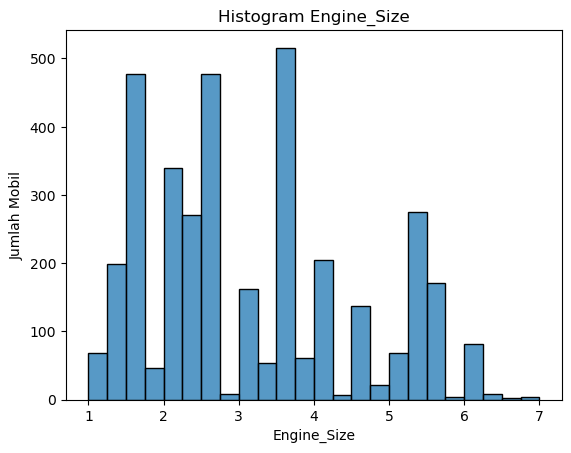

In [267]:
sn.histplot(data_prep['Engine_Size'])
plt.title("Histogram Engine_Size")
plt.ylabel("Jumlah Mobil")

In [268]:
data_prep["Engine_Size"].describe()

count    3666.000000
mean        3.128151
std         1.391606
min         1.000000
25%         2.000000
50%         2.700000
75%         4.000000
max         7.000000
Name: Engine_Size, dtype: float64

Setelah dilakukan filtering outlier maka nilai max engine size menjadi 7 dan nilai min engine size tetap 1.

### Price

In [269]:
detect_outlier(data_prep,data_prep["Price"])

Upper Limit: 183312.5
Lower Limit: -52187.5
Interquartile range: 58875.0
Outlier Upper: 254
Outlier Lower: 0


In [270]:
data_prep["Price"].describe()

count      3666.000000
mean      79288.080469
std       72960.953080
min           1.000000
25%       36125.000000
50%       59000.000000
75%       95000.000000
max      850000.000000
Name: Price, dtype: float64

Terdapat mobil yang harganya 1. Data ini akan didrop. Karena kemungkinan kecil sekali ada harga mobil sebesar 1.

<Axes: ylabel='Price'>

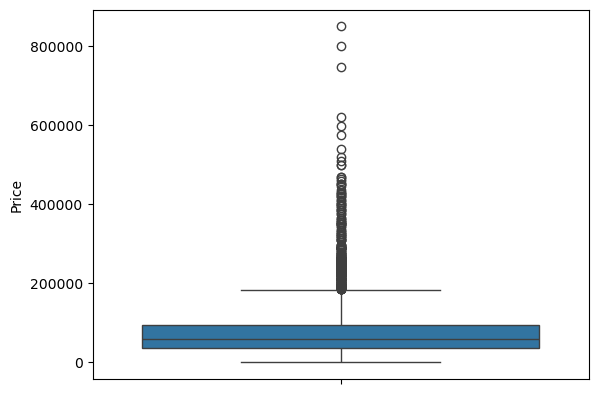

In [271]:
sn.boxplot(data_prep["Price"])

In [272]:
premium_car = data_prep[data_prep["Price"] > 183312.5]["Make"].unique()

In [273]:
exceed_upper_list = []
below_upper_list = []
for car in premium_car:
    maker = data_prep[data_prep["Make"] == car]
    below_upper_list.append(len(maker[maker["Price"] < 183312.5]))
    exceed_upper_list.append(len(maker[maker["Price"] > 183312.5]))

In [274]:
df_premium_car = pd.DataFrame({
    "Maker":premium_car,
    "Exceed Upper limit": exceed_upper_list,
    "Below Upper limit": below_upper_list
})
df_premium_car

,Maker,Exceed Upper limit,Below Upper limit
0,Land Rover,39,21
1,Toyota,49,776
2,Mercedes,59,109
3,Aston Martin,1,1
4,Lexus,47,94
5,BMW,19,53
6,Rolls-Royce,3,0
7,Other,1,3
8,Ford,2,329
9,Nissan,8,232


Berdasarkan data di atas mayoritas brand mobil nilai below upper limit nya lebih besar dari pada exceed upper limit. Oleh karena itu data yang melebihi nilai upper limit sebanyak 254 akan didrop. Namun konsekuensinya kita kehilangan data mobil brand ferrari dan roll-royce karena nila below upper limitnya 0.

In [275]:
data_prep.drop(data_prep[data_prep['Price'] > 183312.5].index, inplace=True) # Drop baris dengan nilai price lebih dari 183312.5
data_prep.drop(data_prep[data_prep['Price'] == 1].index, inplace=True) # Drop baris dengan nilai price = 1

<Axes: xlabel='Price', ylabel='Count'>

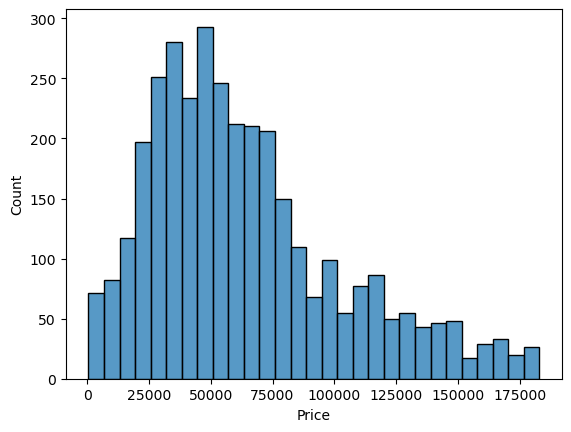

In [276]:
sn.histplot(data_prep["Price"])

In [277]:
data_prep['Price'].describe()

count      3411.000000
mean      63988.772208
std       39324.011015
min         500.000000
25%       35000.000000
50%       55000.000000
75%       83000.000000
max      183000.000000
Name: Price, dtype: float64

Setelah dilakukan filter outlier maka nilai max price menjadi 183000 dan nilai min price menjadi 500.

### Car age

In [278]:
detect_outlier(data_prep,data_prep["car_age"])

Upper Limit: 17.0
Lower Limit: 1.0
Interquartile range: 4.0
Outlier Upper: 222
Outlier Lower: 0


In [342]:
data_prep[data_prep["car_age"] > 17]

,Type,Region,Make,Gear_Type,Origin,Options,Engine_Size,Mileage,Price,car_age
86,Suburban,Al-Medina,Chevrolet,Automatic,Other,Full,5.3,70000,20000,26
114,S,Al-Medina,Mercedes,Automatic,Saudi,Full,3.0,270000,45000,18
182,Suburban,Riyadh,GMC,Automatic,Saudi,Semi Full,5.3,215000,13000,30
197,Opirus,Riyadh,Kia,Automatic,Other,Semi Full,3.5,25500,14000,19
243,Corolla,Riyadh,Toyota,Automatic,Saudi,Full,1.0,50000,15000,22
...,...,...,...,...,...,...,...,...,...,...
5521,Suburban,Al-Medina,Chevrolet,Automatic,Other,Semi Full,6.0,292764,4000,28
5537,Savana,Jeddah,GMC,Automatic,Other,Full,1.5,200000,11500,26
5599,Corolla,Dammam,Toyota,Manual,Other,Standard,1.3,32500,7000,28
5606,Land Cruiser,Al-Baha,Toyota,Automatic,Gulf Arabic,Full,4.6,285,65000,19


Kita akan membiarkan outlier car_age karena jika dihapus model akan kehingan sebagian informasi yang penting. Sebelum nya saya mencoba memnghapus outlier pada car_age namun performa model malah turun.

**Perbedaan jumlah baris dan kolom sebelum dan setelah data preprocessing**

In [279]:
data_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3411 entries, 3 to 5622
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Type         3411 non-null   object 
 1   Region       3411 non-null   object 
 2   Make         3411 non-null   object 
 3   Gear_Type    3411 non-null   object 
 4   Origin       3411 non-null   object 
 5   Options      3411 non-null   object 
 6   Engine_Size  3411 non-null   float64
 7   Mileage      3411 non-null   int64  
 8   Price        3411 non-null   int64  
 9   car_age      3411 non-null   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 293.1+ KB


In [280]:
row_eda = data_eda.shape[0]
kolom_eda = data_eda.shape[1]
row_prep = data_prep.shape [0]
kolom_prep = data_prep.shape [1]
print(f"Jumlah baris & kolom sebelum preprocessing:\nBaris: {row_eda}\nKolom: {kolom_eda}\n")
print(f"Jumlah baris & kolom setelah preprocessing:\nBaris: {row_prep}\nKolom: {kolom_prep}\n")
print(f"Jumlah pengurangan:\nKolom: {kolom_eda-kolom_prep}\nBaris: {row_eda-row_prep}")

Jumlah baris & kolom sebelum preprocessing:
Baris: 5624
Kolom: 11

Jumlah baris & kolom setelah preprocessing:
Baris: 3411
Kolom: 10

Jumlah pengurangan:
Kolom: 1
Baris: 2213


# Data Modeling

Copy data preprocessing ke data yang akan digunakan untuk modeling

In [281]:
data_clean = data_prep.copy()

Deklarasi fitur numerik, kategorik, fitur yang akan diproses oleh binary encoder dan fitur yang akan diproses oleh onehotencoder

In [282]:
categorical_feature = ['Type','Region','Make','Gear_Type','Origin','Options'] # Fitur kategorik
numerical_feature = ['car_age','Mileage','Engine_Size']# Fitur numerik
BinaryEcnode_feature = ['Type','Region','Make'] # Fitur yang akan diproses oleh binary encoder
ohe_feature = ['Gear_Type','Origin','Options'] # Fitur yang akan dirporses oleh onehotencoder


Membuat column transformer yang berisikan binary encoder dan One hot encoder.

In [283]:
ct = ColumnTransformer(
    [
        ('Binary_Encoder',BinaryEncoder(),BinaryEcnode_feature),
        ('OneHotEncoder',OneHotEncoder(drop='first'),ohe_feature),
        ('StandarScaller',StandardScaler(),numerical_feature)
    ], remainder='passthrough'
)

Deklarasi variabel independent dan variable dependent

In [284]:
X = data_clean.drop(columns="Price") # Deklarasi variable independent
y = data_clean["Price"] # Deklarasi variable dependent

Memisah data menjadi train dan test.

In [285]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=1
)

Deklarasi KFold yang akan digunakan pada GridSearch

In [286]:
crossv = KFold(n_splits=5, shuffle=True, random_state=1)

In [287]:
model_list = []
r2_list = []
mae_list = []

Proses selanjutnya adalah experimen untuk memilih model dengan estimator terbaik. Model yang akan digunakan adalah KNN, Decission Tree, Ridge Regresor, Laso Regresor, OLS, Random Forest regresor, dan XGBOOST regresor.

## KNN

In [288]:
knn_pipeline = Pipeline([
    ("Preprocessing",ct),
    ("modelling",KNeighborsRegressor())
])

hyperparameter_space = {
    'modelling__n_neighbors' : np.arange(1, 20)
}

In [289]:
knn_gridcv = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=hyperparameter_space,
    cv= crossv,
    scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],
    refit='r2'
)

knn_gridcv.fit(X_train, y_train)

,estimator,Pipeline(step...Regressor())])
,param_grid,"{'modelling__n_neighbors': array([ 1, 2... 18, 19])}"
,scoring,"['r2', 'neg_mean_absolute_error', ...]"
,n_jobs,None
,refit,'r2'
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('Binary_Encoder', ...), ('OneHotEncoder', ...), ...]"


In [290]:
knn_gridcv.best_params_

{'modelling__n_neighbors': 5}

In [291]:
knn_gridcv.best_score_

0.640305705500023

In [292]:
best_knn = knn_gridcv.best_estimator_
knn_y_pred = best_knn.predict(X_test)
knn_r2 = r2_score(y_true=y_test, y_pred=knn_y_pred)
knn_mae = mean_absolute_error(y_true=y_test, y_pred=knn_y_pred)
print(f"R2: {knn_r2}\nMAE: {knn_mae}")

R2: 0.6593989680530625
MAE: 15198.525915080527


In [293]:
model_list.append("KNN")
r2_list.append(knn_r2)
mae_list.append(knn_mae)

Model KNN Regresor dengan parameter `n_neighbours` = 18. Menghasilkan prediksi dengan R^2 = 0.12, RMSE = 

## Decission Tree

In [294]:
dt_pipeline = Pipeline([
    ("preprocessing",ct),
    ("modelling",DecisionTreeRegressor(random_state=1))
])

hyperparameter_space = {
    'modelling__criterion' : ['absolute_error', 'poisson', 'friedman_mse', 'squared_error'],
    'modelling__max_depth' : [2,3,5,10,20,25],
    'modelling__min_samples_leaf' : [2,3,5,10,20],
    'modelling__splitter' : ['best', 'random']
}

In [295]:
dt_gridcv = GridSearchCV(
    estimator=dt_pipeline,
    param_grid=hyperparameter_space,
    cv=crossv,
    scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],
    refit='r2'
)

dt_gridcv.fit(X_train, y_train)

,estimator,Pipeline(step...om_state=1))])
,param_grid,"{'modelling__criterion': ['absolute_error', 'poisson', ...], 'modelling__max_depth': [2, 3, ...], 'modelling__min_samples_leaf': [2, 3, ...], 'modelling__splitter': ['best', 'random']}"
,scoring,"['r2', 'neg_mean_absolute_error', ...]"
,n_jobs,None
,refit,'r2'
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('Binary_Encoder', ...), ('OneHotEncoder', ...), ...]"


In [296]:
dt_gridcv.best_params_

{'modelling__criterion': 'friedman_mse',
 'modelling__max_depth': 20,
 'modelling__min_samples_leaf': 10,
 'modelling__splitter': 'best'}

In [297]:
dt_gridcv.best_score_

0.561245924384704

In [298]:
best_dt = dt_gridcv.best_estimator_ 
dt_y_pred = best_dt.predict(X_test) 
dt_r2 = r2_score(y_true=y_test, y_pred=dt_y_pred) 
dt_mae = mean_absolute_error(y_true=y_test, y_pred=dt_y_pred) 
print(f"R2: {dt_r2}\nMAE: {dt_mae}")

R2: 0.6025154917230522
MAE: 16124.856093684655


In [299]:
model_list.append("Decission Tree")
r2_list.append(dt_r2)
mae_list.append(dt_mae)

## Ridge

In [300]:
ridge_pipeline = Pipeline([
    ("preprocessing",ct),
    ("modelling",Ridge(random_state=1))
])

hyperparameter_space = {
    'modelling__alpha' : np.logspace(5,-5,50)
}

In [301]:
ridge_gridcv = GridSearchCV(
    estimator=ridge_pipeline,
    param_grid=hyperparameter_space,
    cv=crossv,
    scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],
    refit='r2',
    n_jobs=-1
)

ridge_gridcv.fit(X_train, y_train)

,estimator,Pipeline(step...om_state=1))])
,param_grid,{'modelling__alpha': array([1.0000...00000000e-05])}
,scoring,"['r2', 'neg_mean_absolute_error', ...]"
,n_jobs,-1
,refit,'r2'
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('Binary_Encoder', ...), ('OneHotEncoder', ...), ...]"


In [302]:
ridge_gridcv.best_params_

{'modelling__alpha': 21.209508879201906}

In [303]:
ridge_gridcv.best_score_

0.464858236437615

In [304]:
best_ridge = ridge_gridcv.best_estimator_
ridge_y_pred = best_ridge.predict(X_test)

ridge_r2 = r2_score(y_true=y_test, y_pred=ridge_y_pred)
ridge_mae = mean_absolute_error(y_true=y_test, y_pred=ridge_y_pred)
print(f"R2: {ridge_r2}\nMAE: {ridge_mae}")

R2: 0.47206630993773835
MAE: 20773.058998817432


In [305]:
model_list.append("Ridge")
r2_list.append(ridge_r2)
mae_list.append(ridge_mae)

## Laso

In [306]:
lasso_pipeline = Pipeline([
    ("preprocessing",ct),
    ("modelling",Lasso(random_state=1))
])

hyperparameter_space = {
    'modelling__alpha' : np.logspace(5,-5,50)
}

In [307]:
lasso_gridcv = GridSearchCV(
    estimator=lasso_pipeline,
    param_grid=hyperparameter_space,
    cv=crossv,
    scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],
    refit='r2',
    n_jobs=-1
)

lasso_gridcv.fit(X_train, y_train)

,estimator,Pipeline(step...om_state=1))])
,param_grid,{'modelling__alpha': array([1.0000...00000000e-05])}
,scoring,"['r2', 'neg_mean_absolute_error', ...]"
,n_jobs,-1
,refit,'r2'
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('Binary_Encoder', ...), ('OneHotEncoder', ...), ...]"


In [308]:
lasso_gridcv.best_params_

{'modelling__alpha': 54.286754393238596}

In [309]:
lasso_gridcv.best_score_

0.4641012871033034

In [310]:
best_lasso = lasso_gridcv.best_estimator_
lasso_y_pred = best_lasso.predict(X_test)

lasso_r2 = r2_score(y_true=y_test, y_pred=lasso_y_pred)
lasso_mae = mean_absolute_error(y_true=y_test, y_pred=lasso_y_pred)
print(f"R2: {lasso_r2}\nMAE: {lasso_mae}")

R2: 0.472926526472069
MAE: 20767.0620584064


In [311]:
model_list.append("Lasso")
r2_list.append(lasso_r2)
mae_list.append(lasso_mae)

## Regresi Linear (OLS)

In [312]:
ols_pipeline = Pipeline([
    ("preprocessing",ct),
    ("modelling",LinearRegression())
])

In [313]:
ols_model = ols_pipeline.fit(X_train,y_train)
ols_y_pred = ols_model.predict(X_test)

In [314]:
ols_r2 = r2_score(y_true=y_test, y_pred=ols_y_pred)
ols_mae = mean_absolute_error(y_true=y_test,y_pred=ols_y_pred)
print(f"R2: {ols_r2}\nMAE: {ols_mae}")

R2: 0.46932538847098426
MAE: 20851.345015922772


In [315]:
model_list.append("OLS")
r2_list.append(ols_r2)
mae_list.append(ols_mae)

## Random Forest

In [316]:
randomforest_pipeline = Pipeline([
    ("preprocessing",ct),
    ("modelling",RandomForestRegressor(random_state=1))
])

hyperparameter_space = {
    'modelling__n_estimators': [100, 300, 500],
    'modelling__max_depth': [None, 10, 20],
    'modelling__max_features': ['sqrt', 'log2', 0.5],
    'modelling__bootstrap': [True, False]
}

In [317]:
randomforest_gridcv = GridSearchCV(
    estimator=randomforest_pipeline,
    param_grid=hyperparameter_space,
    cv=crossv,
    scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],
    refit='r2',
    n_jobs=-1
)

randomforest_gridcv.fit(X_train, y_train)

,estimator,Pipeline(step...om_state=1))])
,param_grid,"{'modelling__bootstrap': [True, False], 'modelling__max_depth': [None, 10, ...], 'modelling__max_features': ['sqrt', 'log2', ...], 'modelling__n_estimators': [100, 300, ...]}"
,scoring,"['r2', 'neg_mean_absolute_error', ...]"
,n_jobs,-1
,refit,'r2'
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('Binary_Encoder', ...), ('OneHotEncoder', ...), ...]"


In [318]:
randomforest_gridcv.best_params_

{'modelling__bootstrap': False,
 'modelling__max_depth': 20,
 'modelling__max_features': 'sqrt',
 'modelling__n_estimators': 300}

In [319]:
randomforest_gridcv.best_score_

0.7196760652921232

In [320]:
best_randomforest = randomforest_gridcv.best_estimator_
randomforest_y_pred = best_randomforest.predict(X_test)

randomforest_r2 = r2_score(y_true=y_test, y_pred=randomforest_y_pred)
randomforest_mae = mean_absolute_error(y_true=y_test, y_pred=randomforest_y_pred)
print(f"R2: {randomforest_r2}\nMAE: {randomforest_mae}")

R2: 0.7196772591795477
MAE: 12732.587696804821


In [321]:
model_list.append("Random Forest")
r2_list.append(randomforest_r2)
mae_list.append(randomforest_mae)

## XGBoost

In [322]:
xgboost_pipeline = Pipeline([
    ("preprocessing",ct),
    ("modelling",XGBRegressor(random_state=1))
])

hyperparameter_space = {
    'modelling__n_estimators': [100, 300, 500],
    'modelling__max_depth': [None, 10, 20],
    'modelling__learning_rate' : np.linspace(1,10,10)/100

}

In [323]:
xgboost_gridcv = GridSearchCV(
    estimator=xgboost_pipeline,
    param_grid=hyperparameter_space,
    cv=crossv,
    scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],
    refit='r2',
    n_jobs=-1
)

xgboost_gridcv.fit(X_train, y_train)

,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'modelling__learning_rate': array([0.01, ..., 0.09, 0.1 ]), 'modelling__max_depth': [None, 10, ...], 'modelling__n_estimators': [100, 300, ...]}"
,scoring,"['r2', 'neg_mean_absolute_error', ...]"
,n_jobs,-1
,refit,'r2'
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('Binary_Encoder', ...), ('OneHotEncoder', ...), ...]"


In [324]:
xgboost_gridcv.best_params_

{'modelling__learning_rate': 0.05,
 'modelling__max_depth': None,
 'modelling__n_estimators': 500}

In [325]:
xgboost_gridcv.best_score_

0.7308169364929199

In [326]:
best_xgboost = xgboost_gridcv.best_estimator_
xgboost_y_pred = best_xgboost.predict(X_test)

xgboost_r2 = r2_score(y_true=y_test, y_pred=xgboost_y_pred)
xgboost_mae = mean_absolute_error(y_true=y_test, y_pred=xgboost_y_pred)
print(f"R2: {xgboost_r2}\nMAE: {xgboost_mae}")

R2: 0.7508167624473572
MAE: 12104.732421875


In [327]:
model_list.append("XGBoost")
r2_list.append(xgboost_r2)
mae_list.append(xgboost_mae)

## Best Model

In [328]:
model_df = pd.DataFrame({
    "Model": model_list,
    "R2": r2_list,
    "MAE": mae_list,
})
model_df.sort_values("R2", ascending=False).reset_index(drop=True)

,Model,R2,MAE
0,XGBoost,0.750817,12104.732422
1,Random Forest,0.719677,12732.587697
2,KNN,0.659399,15198.525915
3,Decission Tree,0.602515,16124.856094
4,Lasso,0.472927,20767.062058
5,Ridge,0.472066,20773.058999
6,OLS,0.469325,20851.345016


Setalah dilakukan eksperimen model yang akan digunakan nilai R2 dan MAE untuk setiap model di kumpulkan pada sebuah tabel. Model terbaik dipilih berdasarkan nilai R2 terbesar dan nilai MAE terkecil. Terlihat bahwa model model ensemble yaitu XGBoost dan Random Forest mengungguli base model seperti KNN, Decission Tree, Ridge, Lasso dan OLS. Model XGBoost adalah model terbaik dengan parameter `learning_rata` = 0.5, `max_depth` = None, dan `n_estimator` = 500. Hasil evaluasi matrik untuk model XGBosst: nilai R2 = 0.75, artinya model ini mampu menjelaskan variansi variasi target data sebesar 75%. Nilai MAE = 124104 mengindikasikan nilai absolut rata-rata antara prediksi harga mobil dan aktual harga mobil adalah sebesar 124104  Oleh karena itu XGBoost dipilih sebagai model untuk memprediksi harga mobil mobil bekas.

Text(0, 0.5, 'Predicted Price')

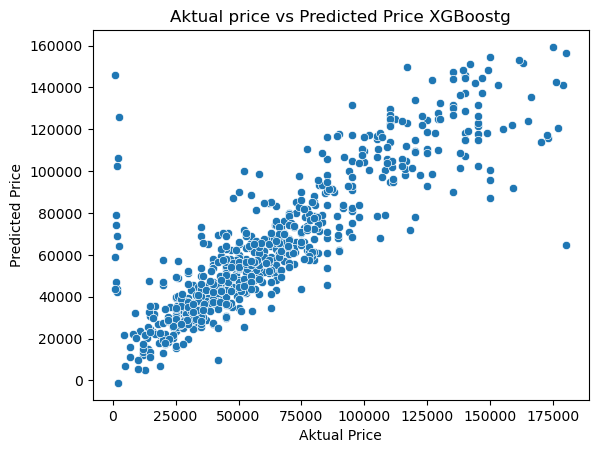

In [329]:
best_model = xgboost_gridcv.best_estimator_
best_y_pred = best_model.predict(X_test)
sn.scatterplot(x=y_test, y=best_y_pred)
plt.title("Aktual price vs Predicted Price XGBoostg")
plt.xlabel("Aktual Price")
plt.ylabel("Predicted Price")

Berdasarkan plot aktual price vs predicted price di atas. Dapat dilihat bahwa titik plot membentuk cluster berbentuk garis yang cukup ketat. Hal ini menandakan bahwa moodel dapat memprediksi harga mobil bekas dengan cukup baik. Namun performa model pada aktual price yang rendah di dekat nilai nol masih belum baik. Hal tersebut dapat dilihat dari adanya outlier.

## Feature Importance

Text(0.5, 1.0, 'XGBoost Feature Importances')

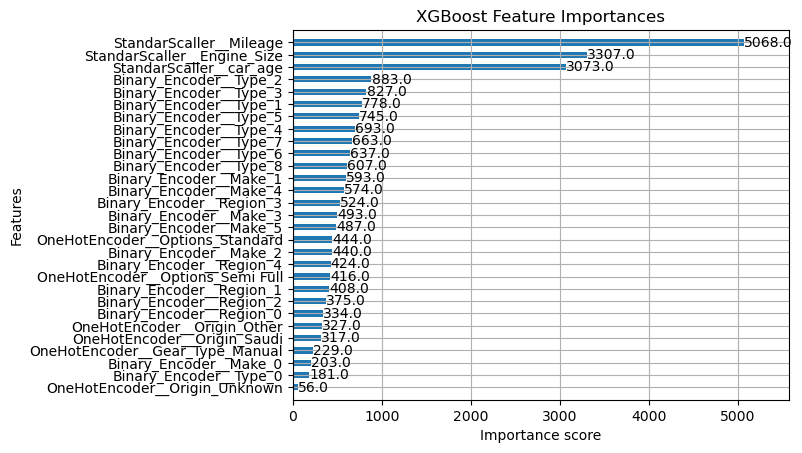

In [340]:
preprocessor = best_model.named_steps['preprocessing']
feature_name = preprocessor.get_feature_names_out()
ax = plot_importance(best_model.named_steps['modelling'], height=0.5)
ax.set_yticklabels([feature_name[int(label.get_text()[1:])] for label in ax.get_yticklabels()])
plt.title("XGBoost Feature Importances")

Berdasarkan plot feature importance di atas. Dapat dilihat bahwa fitur yang paing berpengaruh adalah Jarak tempuh mobil, ukuran mesin mobil, dan umur mobil.

**SHAP**

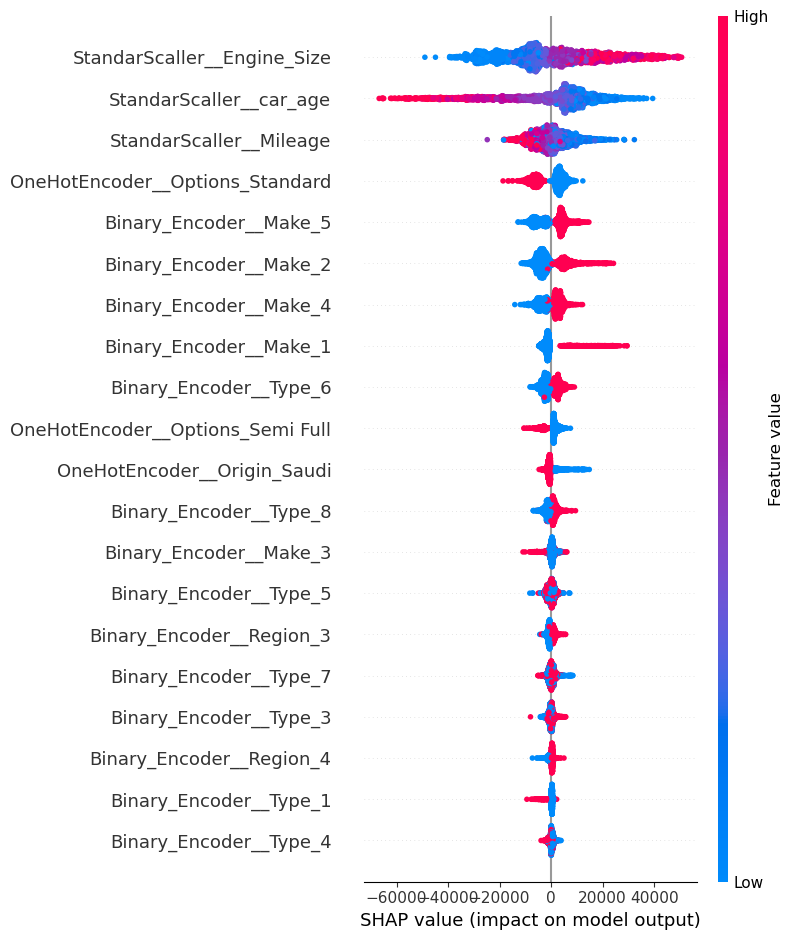

In [341]:
model = best_model.named_steps['modelling'] # Ekstrak best model dari pipeline
preprocessor = best_model.named_steps['preprocessing'] # Ekstrak preprocessor dari pipeline
feature_name = preprocessor.get_feature_names_out() # Ekstrak nama feature setelah proses preprocessing
explainer = shap.TreeExplainer(model) # Instantiate tree explainer
X_train_transformed = ct.fit_transform(X_train) # transfor X_train
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_name) # Rubah X_train ke dataframe
shap_values = explainer.shap_values(X_train_transformed) # fit shap value menggunakan x transformed
shap.summary_plot(shap_values, X_train_transformed_df) # plot SHAP

Interpretasi:
1. Semakin tua sebuah mobil maka harga mobil akan semakin turun.
2. Semakin besar ukuran mesin mobil maka harga mobil akan semakin tinggi.
3. Semakin rendah jarak tempuh mobil maka harga mobil akan semakin tinggi.

# Kesimpulan Rekomendasi

**Kesimpulan:**

1. Model XGBoost adalah model machine learning terbaik untuk memprediksi harga mobil bekas dengan score R2 = 75% dan MAE = 12104.

2. Tiga faktor yang paling mempengaruhi harga jual mobil bekas adalah. Jarak tempuh kendaraan, ukuran mesin mobil, dan umur mobil.
- Semakin tua sebuah mobil maka harga mobil akan semakin turun.
- Semakin besar ukuran mesin mobil maka harga mobil akan semakin tinggi.
- Semakin rendah jarak tempuh mobil maka harga mobil akan semakin tinggi.

3. Hasil prediksi mobil bekas cukup baik. Model dapat memprediksi harga mobil bekas dengan nilai mean absolut error sebesar 12104. Artinya deviasi antara harga prediksi dengan harga aktual sebesar 12104.

**Limitasi:**

1. Adapun limitasi model ini adalah tidak bisa melakukan extrapolasi. Rentang nilai yang dapat diprediksi adalah rentang nilai yang pernah dilihat pada saat pelatihan model. Jika diberikan input di luar rentang pelatihan maka prediksinya biasanya akan mendekaati nilai maksimum  dari range pelatihan. Misal jika kita memasukan nilai mileage sebesar 500.000 mil yang mana melebihi nilai batas atas mileage sebesar 384000 maka model akan memprediksi harga mobil tersebut mendekati harga mobil yang mileagenya 385.000.
2. Konsekuensi dari poin satu adalah model hanya dapat dipercaya jika input nilai sebagai berikut:
- Mileage rentang 100 - 38400
- Engine rentang size 1 - 7
- Tipe dan merk mobil yang seduah pernah dilihat di data training.

**Rekomendasi**:

1. Model masih dapat ditingkatkan dengan menambah fitur lain yang menjelaskan kondisi mobil bekas seperti apakah mobil pernah mengalama kecelakaan atau tidak, jumlah kepemilikan mobil sebelumnya, history perbaikan mobil.
2. Memperbaiki model dengan cara preprocessing data lebih lanjut atau menggunakan model seperti deep learning untuk mengeliminasi outlier di grafik aktual price vs predicted price. Sehingga performa model meningkat.
3. Membuat sebuah website yang sederhana di mana user menginput spesifikasi mobil bekas lalu user bisa mendapatkan prediksi harga mobil bekas berdasarkan model yang telah dibangun.

# Studi Case

In [332]:
to_predict = pd.DataFrame({
    'Type': ['Hilux'],
    'Region' : ['Riyadh'],
    'Make' : ['Toyota'],
    'Gear_Type' : ['Automatic'],
    'Origin' : ['Saudi'],
    'Options' : ['Standard'],
    'Engine_Size' : [2.7],
    'Mileage' : [40000],
    'car_age' : [10],
})
actual_price = 50000

In [333]:
predicted_price = best_model.predict(to_predict)
mae_study_case = xgboost_mae
print(f"Actual car price: {actual_price}\nPredicted car price: {predicted_price[0]} +- {mae_study_case}")
if actual_price > predicted_price:
    print(f"Actual price lebih besar dari predicted prise. Harga mobil overprice.")
else:
    print(f"Actual price lebih kecil dari predicted prise. Harga mobil underprice.")

Actual car price: 50000
Predicted car price: 64377.546875 +- 12104.732421875
Actual price lebih kecil dari predicted prise. Harga mobil underprice.


# Save Model

**Save Model**

In [334]:
import pickle

In [335]:
estimator = best_model.fit(X_train, y_train)

In [336]:
pickle.dump(estimator, open('Used_car_price_XGB.sav', 'wb'))

**Load Model**

In [337]:
filename = 'Used_car_price_XGB.sav'

In [338]:
loaded_model = pickle.load(open(filename, 'rb'))

In [339]:
r2_score(y_test, loaded_model.predict(X_test))

0.7508167624473572